Model A- Weather Trend Forecasting using XGBoost.

Basic Dataset Info:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                   

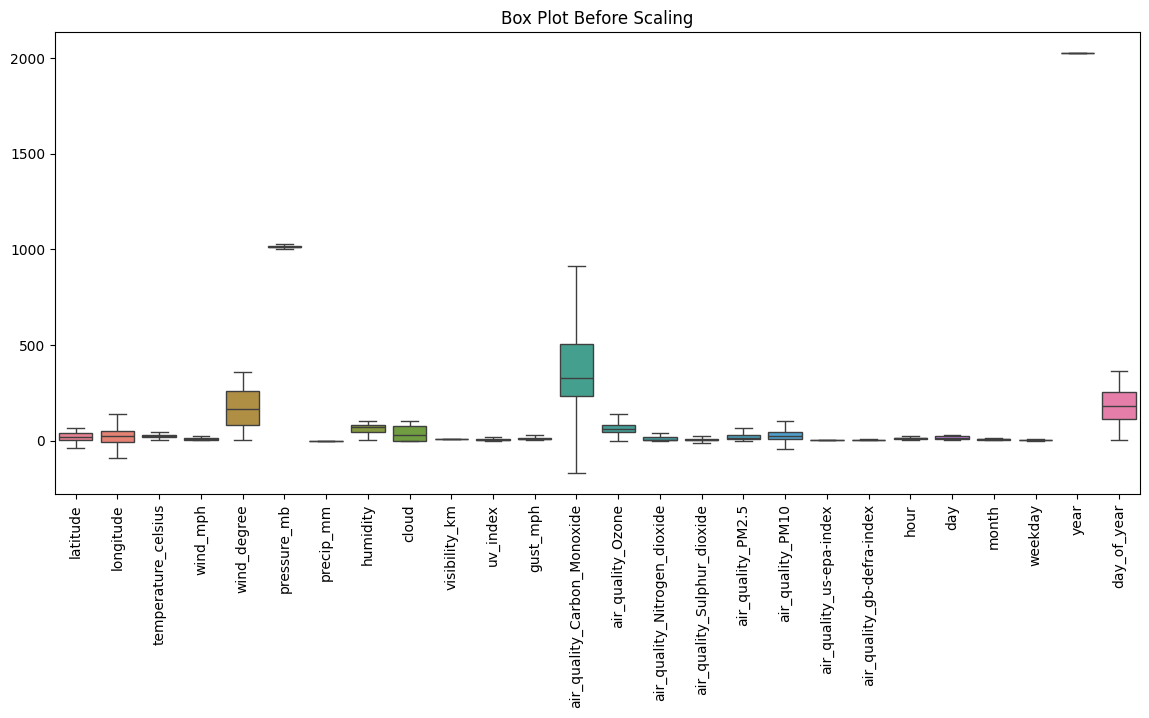

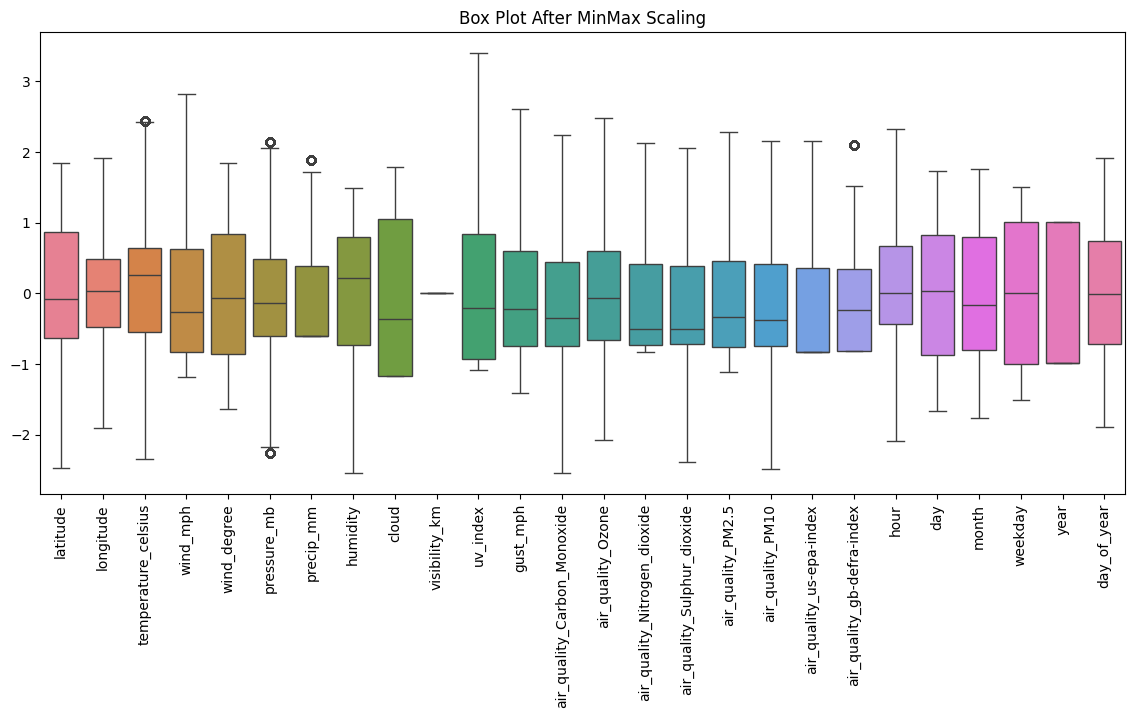

[0]	validation_0-merror:0.52237
[1]	validation_0-merror:0.41644
[2]	validation_0-merror:0.41133
[3]	validation_0-merror:0.36512
[4]	validation_0-merror:0.34724
[5]	validation_0-merror:0.33453
[6]	validation_0-merror:0.33084
[7]	validation_0-merror:0.33850
[8]	validation_0-merror:0.34054
[9]	validation_0-merror:0.34520
[10]	validation_0-merror:0.34401
[11]	validation_0-merror:0.33731
[12]	validation_0-merror:0.34384
[13]	validation_0-merror:0.34003
[14]	validation_0-merror:0.33651
[15]	validation_0-merror:0.33810
[16]	validation_0-merror:0.33498
[17]	validation_0-merror:0.33214
[18]	validation_0-merror:0.33243
[19]	validation_0-merror:0.32834
[20]	validation_0-merror:0.32913
[21]	validation_0-merror:0.32675
[22]	validation_0-merror:0.32669
[23]	validation_0-merror:0.32300
[24]	validation_0-merror:0.32346
[25]	validation_0-merror:0.32329
[26]	validation_0-merror:0.31897
[27]	validation_0-merror:0.31772
[28]	validation_0-merror:0.31585
[29]	validation_0-merror:0.31403
[30]	validation_0-me

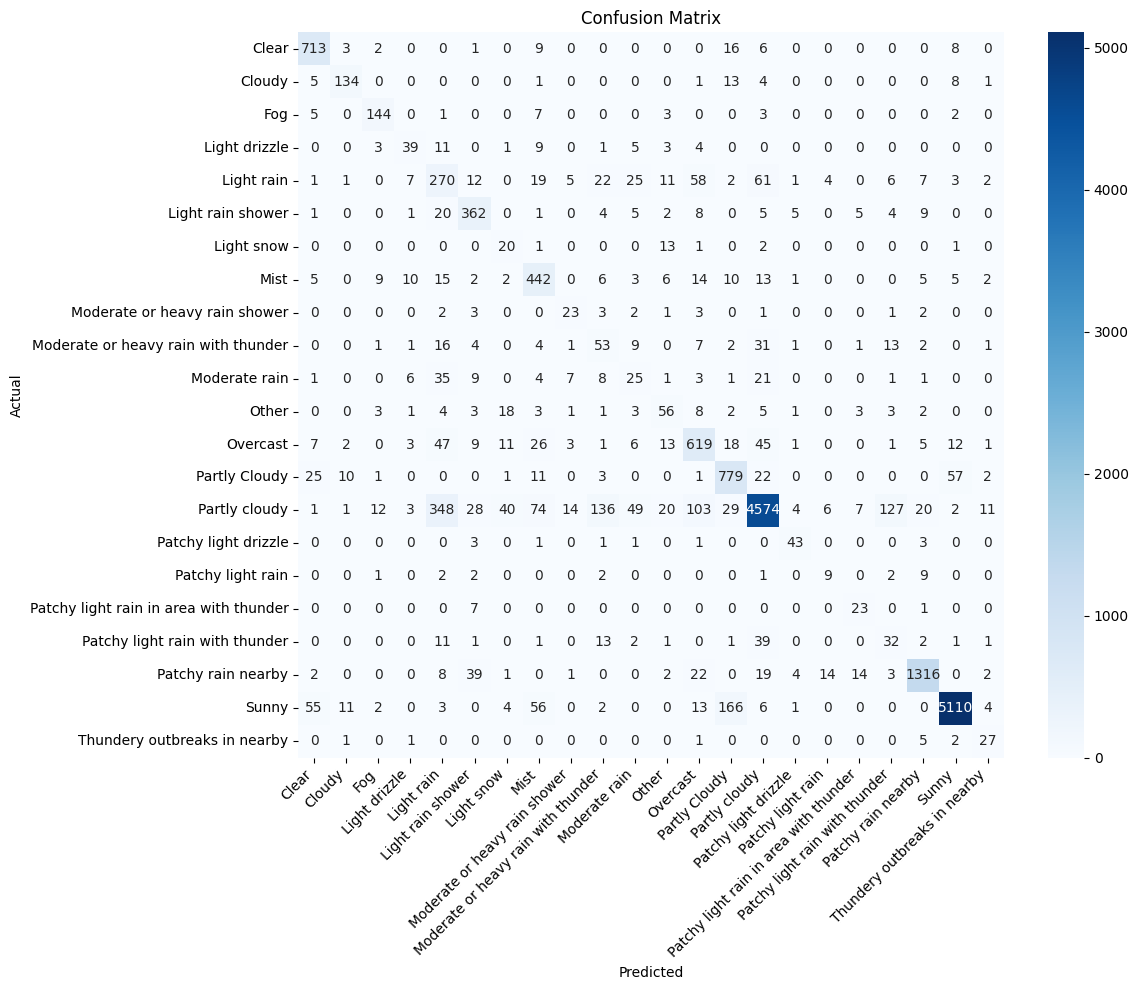

<Figure size 1200x800 with 0 Axes>

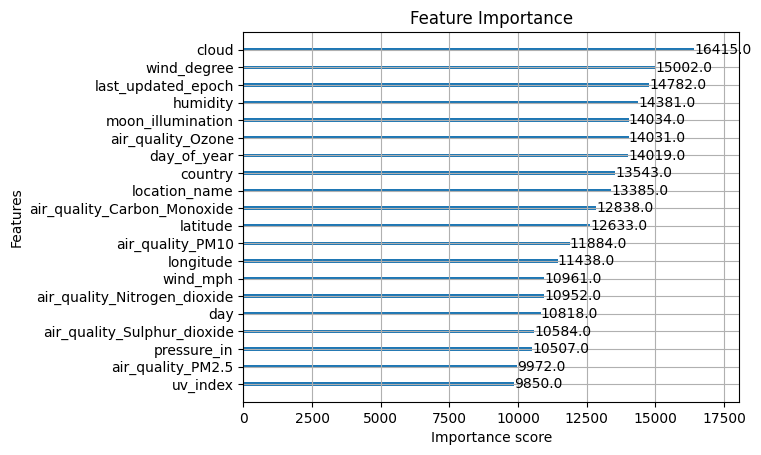


Sample predictions:
                   Actual           Predicted
1056                Sunny               Sunny
2177                Sunny               Sunny
13228       Partly cloudy       Partly cloudy
1981                Sunny               Sunny
3315        Partly cloudy            Overcast
884    Patchy rain nearby  Patchy rain nearby
17033       Partly cloudy       Partly cloudy
6390        Partly cloudy       Partly cloudy
9109                Sunny               Sunny
10798              Cloudy              Cloudy


In [10]:
# --- Model A: Weather Trend Forecasting using XGBoost ---

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTENC
from xgboost import plot_importance

# 2. Read data
df = pd.read_csv('/content/GlobalWeatherRepository.csv')
print("Basic Dataset Info:")
print(df.head())
print(df.info())
print(df.describe())
print(df.columns)
print("\nNull values per column:")
print(df.isna().sum())

# 3. Drop unusable object columns for XGBoost
drop_cols = ['timezone', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'last_updated']

# 4. Feature engineering: datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])
df['hour'] = df['last_updated'].dt.hour
df['day'] = df['last_updated'].dt.day
df['month'] = df['last_updated'].dt.month
df['weekday'] = df['last_updated'].dt.weekday
df['year'] = df['last_updated'].dt.year
df['day_of_year'] = df['last_updated'].dt.dayofyear

# 5. Define feature groups
geo_features = ['latitude', 'longitude']
weather_features = [
    'temperature_celsius', 'wind_mph', 'wind_degree', 'pressure_mb',
    'precip_mm', 'humidity', 'cloud', 'visibility_km', 'uv_index', 'gust_mph'
]
air_quality_features = [
    'air_quality_Carbon_Monoxide', 'air_quality_Ozone',
    'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10',
    'air_quality_us-epa-index', 'air_quality_gb-defra-index'
]
time_features = ['hour', 'day', 'month', 'weekday', 'year', 'day_of_year']
categorical_features = ['country', 'location_name', 'condition_text', 'wind_direction']

numeric_cols = geo_features + weather_features + air_quality_features + time_features

# 6. Data cleaning and preprocessing
# Handle missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# --- Helper: Clip outliers ---
def clip_outliers(df, cols, k=1.5):
    for col in cols:
        series = df[col].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        df[col] = np.clip(df[col], lower, upper)
    return df

df = clip_outliers(df, numeric_cols)

# --- Model A: Weather Trend Forecasting using XGBoost ---

# [Previous imports and data loading remain the same until rare class merging...]

# --- Enhanced Rare class merge: BEFORE encoding ---
condition_counts = df['condition_text'].value_counts()
rare_threshold = 100  # Increased threshold from 20 to 50
rare_conditions = condition_counts[condition_counts < rare_threshold].index
df['condition_text'] = df['condition_text'].replace(rare_conditions, 'Other')

print(f"\nOriginal number of weather conditions: {len(condition_counts)}")
print(f"Number of rare conditions (less than {rare_threshold} samples): {len(rare_conditions)}")
print(f"Number of conditions after merging: {len(df['condition_text'].unique())}")

# Before scaling
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title("Box Plot Before Scaling")
plt.show()

# --- Encode categorical features ---
df_encoded = df.copy()
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le



# --- Scale numeric features ---
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_scaled[numeric_cols])
plt.xticks(rotation=90)
plt.title("Box Plot After MinMax Scaling")
plt.show()


# --- Prepare X and y ---
X = df_encoded.drop(columns=['condition_text'] + drop_cols, errors='ignore')
y = df_encoded['condition_text']

# --- Stratified split with validation ---
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Further split training set for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# --- Enhanced Class Weighting ---
class_counts = np.bincount(y_train)
median_count = np.median(class_counts[class_counts > 0])  # Avoid division by zero

# Aggressive weighting: 10x weight for classes <50 samples, 5x for <100, etc.
weight_factors = np.where(
    class_counts < 50, 10,
    np.where(class_counts < 100, 5,
    np.where(class_counts < 200, 2, 1))
)

class_weights = median_count / (class_counts + 1) * weight_factors  # +1 to avoid division by zero
sample_weights = np.array([class_weights[cls] for cls in y_train])

# --- Train XGBoost with Enhanced Settings ---
model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='merror',  # Changed from mlogloss to merror for better interpretation
    n_estimators=1000,  # Increased to compensate for early stopping
    max_depth=5,  # Reduced from 6 to prevent overfitting
    learning_rate=0.05,  # Reduced from 0.1 for better generalization
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,  # L1 regularization
    reg_lambda=1,  # L2 regularization
    min_child_weight=3,  # More conservative splitting
    random_state=42,
    early_stopping_rounds=30,  # Increased patience
    n_jobs=-1  # Use all cores
)

# Train WITHOUT SMOTE
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,  # Using our aggressive weights
    eval_set=[(X_val, y_val)],
    verbose=True
)

y_pred = model.predict(X_test)

# --- Evaluation ---
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Confusion Matrix ---
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['condition_text'].classes_,
            yticklabels=label_encoders['condition_text'].classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Feature importance ---
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20)
plt.title('Feature Importance')
plt.show()

# --- Sample predictions ---
sample_results = pd.DataFrame({
    'Actual': label_encoders['condition_text'].inverse_transform(y_test),
    'Predicted': label_encoders['condition_text'].inverse_transform(y_pred)
}).sample(10, random_state=42)

print("\nSample predictions:")
print(sample_results)

In [11]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd

# Scale numeric features
lstm_features = numeric_cols  # numeric only
scaler = MinMaxScaler()
df[lstm_features] = scaler.fit_transform(df[lstm_features])

# Sort data chronologically for each location
df = df.sort_values(['location_name', 'last_updated'])

# Encode target labels
lstm_label_encoder = LabelEncoder()
df['condition_label'] = lstm_label_encoder.fit_transform(df['condition_text'])

# Updated create_sequences() to also return indices
def create_sequences(group, seq_length=24):
    X, y, idx = [], [], []
    data = group[lstm_features].values
    labels = group['condition_label'].values
    indices = group.index.values  # Keep original index positions

    for i in range(len(group) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length])
        idx.append(indices[i+seq_length])  # Save the label's index for alignment later

    return np.array(X), np.array(y), np.array(idx)

seq_length = 24
X_lstm_list, y_lstm_list, idx_list = [], [], []

# Build sequences per location
for _, group in df.groupby('location_name'):
    if len(group) > seq_length:
        X_seq, y_seq, idx_seq = create_sequences(group, seq_length)
        if X_seq.size > 0:
            X_lstm_list.append(X_seq)
            y_lstm_list.append(y_seq)
            idx_list.append(idx_seq)

# Combine into full arrays
X_lstm = np.vstack(X_lstm_list)
y_lstm = np.concatenate(y_lstm_list)
seq_indices = np.concatenate(idx_list)  # for alignment with XGBoost

# One-hot encode LSTM labels
y_lstm_cat = to_categorical(y_lstm, num_classes=len(lstm_label_encoder.classes_))

print("LSTM Input shape:", X_lstm.shape)
print("Seq Indices shape:", seq_indices.shape)


LSTM Input shape: (83040, 24, 26)
Seq Indices shape: (83040,)


In [12]:
X_xgb = df.loc[seq_indices, numeric_cols + categorical_features].copy()
X_xgb_encoded = pd.get_dummies(X_xgb, columns=categorical_features)

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test, \
X_xgb_train, X_xgb_test = train_test_split(
    X_lstm, y_lstm, X_xgb_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_lstm
)

# One-hot labels for LSTM
y_lstm_cat_train = to_categorical(y_lstm_train, num_classes=len(lstm_label_encoder.classes_))
y_lstm_cat_test  = to_categorical(y_lstm_test,  num_classes=len(lstm_label_encoder.classes_))


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score

lstm_model = Sequential([
    LSTM(64, input_shape=(seq_length, len(lstm_features)), return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(lstm_label_encoder.classes_), activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.fit(
    X_lstm_train, y_lstm_cat_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_lstm_test, y_lstm_cat_test)
)

# LSTM predictions
p_lstm_only = lstm_model.predict(X_lstm_test)
lstm_preds = np.argmax(p_lstm_only, axis=1)

print("LSTM Accuracy:", accuracy_score(y_lstm_test, lstm_preds))
print("\nClassification Report (LSTM only):")
print(classification_report(y_lstm_test, lstm_preds, target_names=lstm_label_encoder.classes_))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4394 - loss: 1.8797 - val_accuracy: 0.5145 - val_loss: 1.5728
Epoch 2/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5125 - loss: 1.5969 - val_accuracy: 0.5305 - val_loss: 1.5169
Epoch 3/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5277 - loss: 1.5493 - val_accuracy: 0.5371 - val_loss: 1.4897
Epoch 4/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5410 - loss: 1.5107 - val_accuracy: 0.5530 - val_loss: 1.4526
Epoch 5/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5491 - loss: 1.4768 - val_accuracy: 0.5581 - val_loss: 1.4356
Epoch 6/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5528 - loss: 1.4582 - val_accuracy: 0.5599 - val_loss: 1.4312
Epoch 7/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5560 - loss: 1.4499 - val_accuracy: 0.5637 - val_loss: 1.4152
Epoch 8/50
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5609 - loss: 1.4

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_xgb_train, y_lstm_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
# LSTM probabilities
p_lstm = lstm_model.predict(X_lstm_test)

# XGBoost probabilities
p_xgb = model.predict_proba(X_xgb_test)

# Weighted average ensemble
alpha = 0.6
final_probs = alpha * p_lstm + (1 - alpha) * p_xgb
final_preds = np.argmax(final_probs, axis=1)

# Decode labels
final_labels = lstm_label_encoder.inverse_transform(final_preds)


519/519 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
from sklearn.metrics import accuracy_score, classification_report

print("Ensemble Accuracy:", accuracy_score(y_lstm_test, final_preds))
print(classification_report(
    y_lstm_test,
    final_preds,
    target_names=lstm_label_encoder.classes_
))

Ensemble Accuracy: 0.958092485549133
                                        precision    recall  f1-score   support

                                 Clear       0.97      0.97      0.97       717
                                Cloudy       1.00      0.84      0.91       164
                                   Fog       0.99      0.98      0.98       164
                         Light drizzle       1.00      0.92      0.96        74
                            Light rain       1.00      0.89      0.94       487
                     Light rain shower       1.00      0.97      0.98       414
                            Light snow       1.00      1.00      1.00        38
                                  Mist       0.99      0.91      0.95       526
         Moderate or heavy rain shower       1.00      0.78      0.88        37
   Moderate or heavy rain with thunder       1.00      0.75      0.85       130
                         Moderate rain       1.00      0.88      0.93       113
  

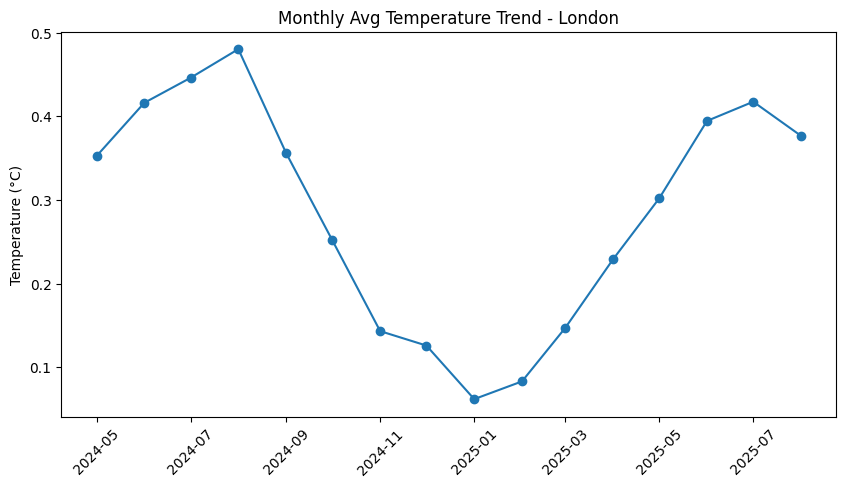

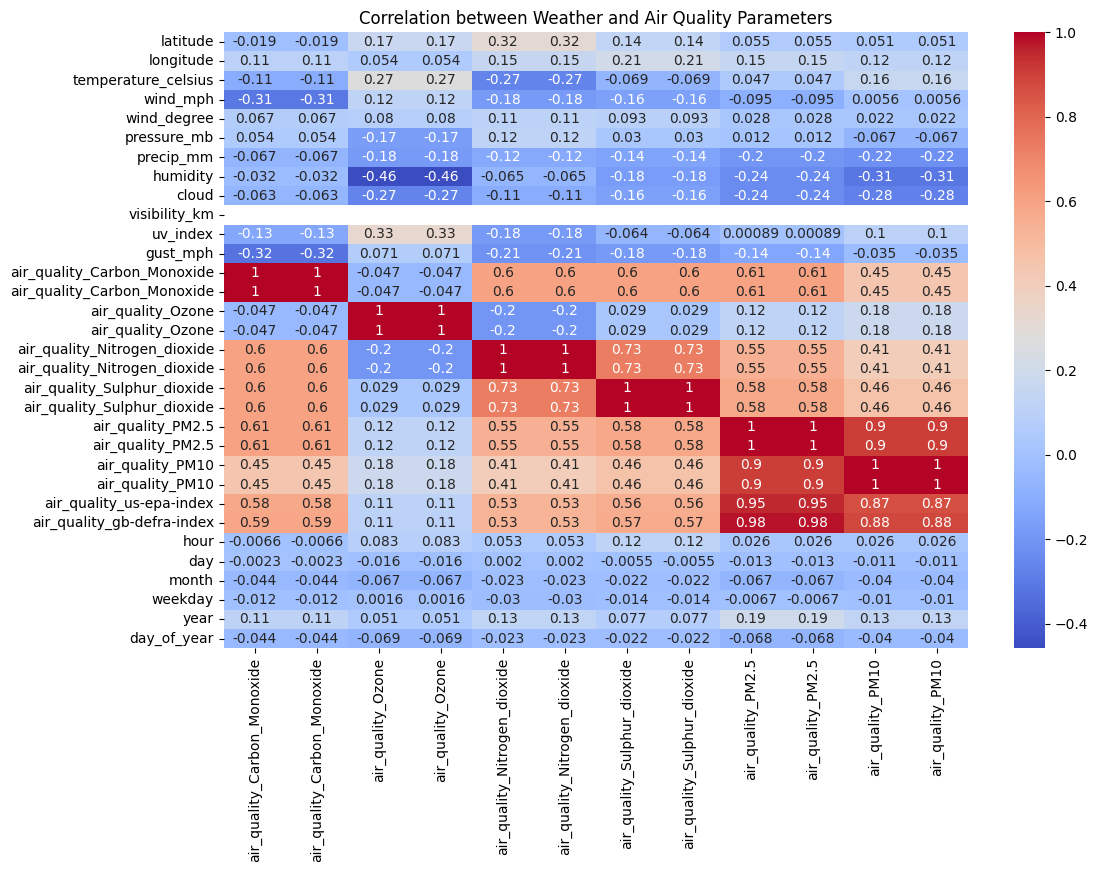

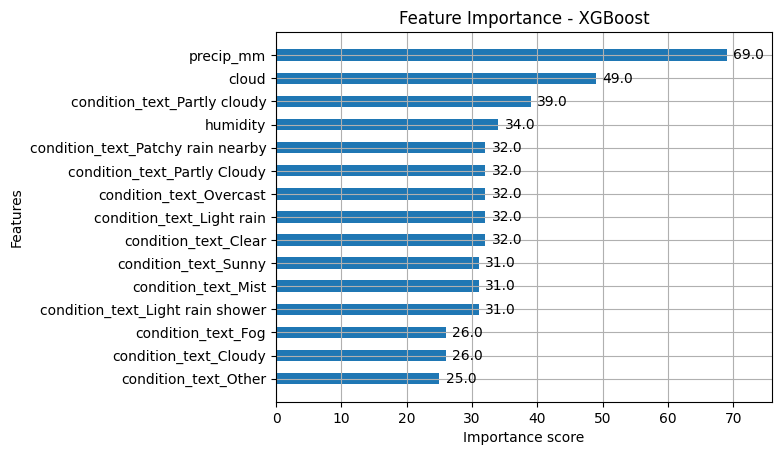

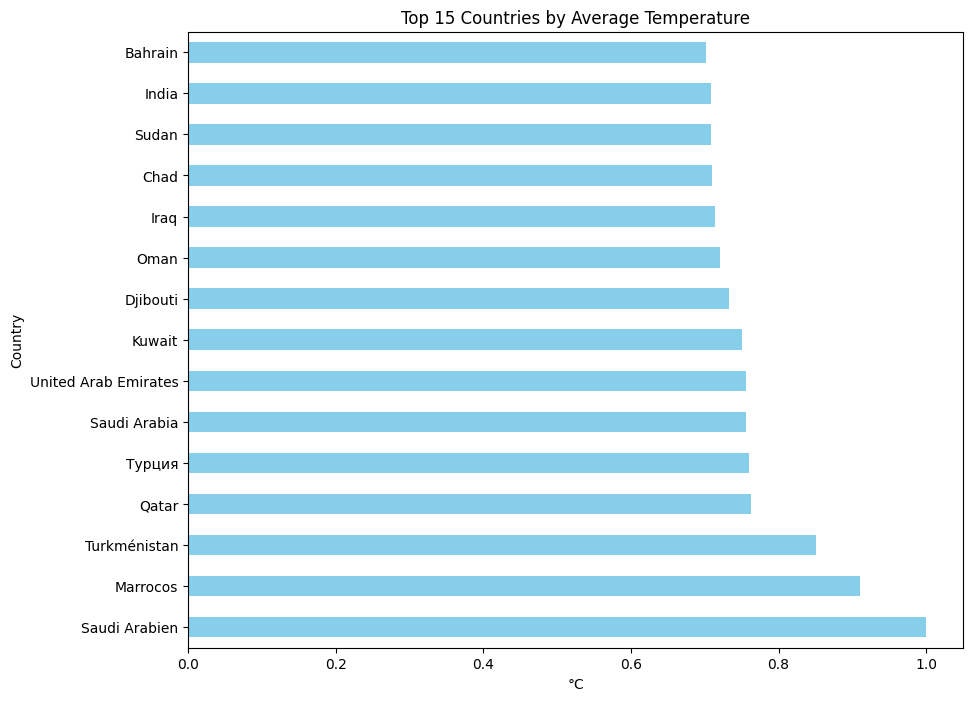

In [20]:
# Step 1: Create year-month as datetime in your groupby output
climate_monthly = df.groupby([
    df['last_updated'].dt.to_period('M'),  # month-year
    'location_name'
])['temperature_celsius'].mean().reset_index()

# Step 2: Convert period to timestamp for plotting
climate_monthly['month_start'] = climate_monthly['last_updated'].dt.to_timestamp()

# Step 3: Filter and plot
sample_loc = "London"
sample_data = climate_monthly[climate_monthly['location_name'] == sample_loc]

plt.figure(figsize=(10,5))
plt.plot(sample_data['month_start'], sample_data['temperature_celsius'], marker='o')
plt.title(f"Monthly Avg Temperature Trend - {sample_loc}")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.show()


air_cols = ['air_quality_Carbon_Monoxide', 'air_quality_Ozone',
            'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
            'air_quality_PM2.5', 'air_quality_PM10']

# Compute correlations
corr_matrix = df[numeric_cols + air_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix[air_cols].loc[numeric_cols], annot=True, cmap="coolwarm")
plt.title("Correlation between Weather and Air Quality Parameters")
plt.show()


import xgboost as xgb

model = xgb.XGBClassifier()
X = pd.get_dummies(df[numeric_cols + categorical_features], columns=categorical_features)
y = lstm_label_encoder.fit_transform(df['condition_text'])
model.fit(X, y)

xgb.plot_importance(model, max_num_features=15, height=0.5)
plt.title("Feature Importance - XGBoost")
plt.show()


import folium

m = folium.Map(location=[0,0], zoom_start=2)
for _, row in df.sample(500).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        popup=f"{row['location_name']} - {row['condition_text']}",
        color='blue' if row['temperature_celsius'] < 15 else 'red',
        fill=True
    ).add_to(m)

m.save("weather_map.html")


# Show top 15 warmest countries
top_countries = country_avg_temp.tail(15)

plt.figure(figsize=(10,8))
top_countries.plot(kind='barh', color='skyblue')
plt.title("Top 15 Countries by Average Temperature")
plt.xlabel("°C")
plt.ylabel("Country")
plt.gca().invert_yaxis()  # warmest at top
plt.show()
